In [1]:
import numpy as np
import pickle
import os
# import glob
from plyfile import PlyData
import src.utils as utils

data = PlyData.read('datasets/dragon_vrip.ply')
# convert numpy array of vertex 3-tuples to a numpy array of shape (N, 3)
print(f"Number of vertices in the dataset: {len(data['vertex'].data)}")

vertices = np.array([list(vertex) for vertex in data['vertex'].data])
# #save vertices on disk
# np.save('datasets/dragon_vrip_vertices.npy', vertices)

rng = np.random.default_rng()
sample_sizes = range(500, 4000 + 500, 500)  # Sample sizes from 500 to 4000 in steps of 500
# sampled_data = {}

# # Delete previously created sampled files
# for file in glob.glob('datasets/dragon_[0-9]*.npy'):
#     os.remove(file)

# for size in sample_sizes:
#     sampled_data[f'sampled_{size}'] = rng.choice(vertices, size, replace=False)
#     np.save(f'datasets/dragon_{size}.npy', sampled_data[f'sampled_{size}'])

max_dimension = 3  # Maximum dimension for the simplicial complex
complex_res = {}
for size in sample_sizes:
    sample = rng.choice(vertices, size, replace=False)
    # print(f"\nPROCESSING DRAGON {size} WITH {len(sample)} POINTS")
    max_edge_length = utils.estimate_max_edge_length(sample)
    complex_res[f"dragon {size}"] = utils.create_complexes(point_cloud=sample, max_edge_length=max_edge_length, max_dimension=max_dimension)

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Save complex_res to disk
with open('results/dragon_complexes.pkl', 'wb') as f:
    pickle.dump(complex_res, f)
print(f"\nSaved complexes for {len(complex_res)} samples to 'results/dragon_complexes.pkl'")

Number of vertices in the dataset: 437645

Saved complexes for 8 samples to 'results/dragon_complexes.pkl'


In [2]:
utils.print_performance_table(complex_res)


PERFORMANCE SUMMARY TABLE
Sample         Rips              Cech              Delaunay Cech     Alpha             Delaunay Alpha    Witness           Relaxed Witness   Strong Witness    
------------------------------------------------------------------------------------------------------------------------
PROCESSING TIME (s)
------------------------------------------------------------------------------------------------------------------------
dragon 500     0.002             0.011             0.012             0.015             0.016             0.002             0.003             0.001             
dragon 1000    0.015             0.027             0.027             0.034             0.034             0.005             0.009             0.003             
dragon 1500    0.060             0.043             0.042             0.053             0.056             0.008             0.022             0.006             
dragon 2000    0.240             0.057             0.057             0.

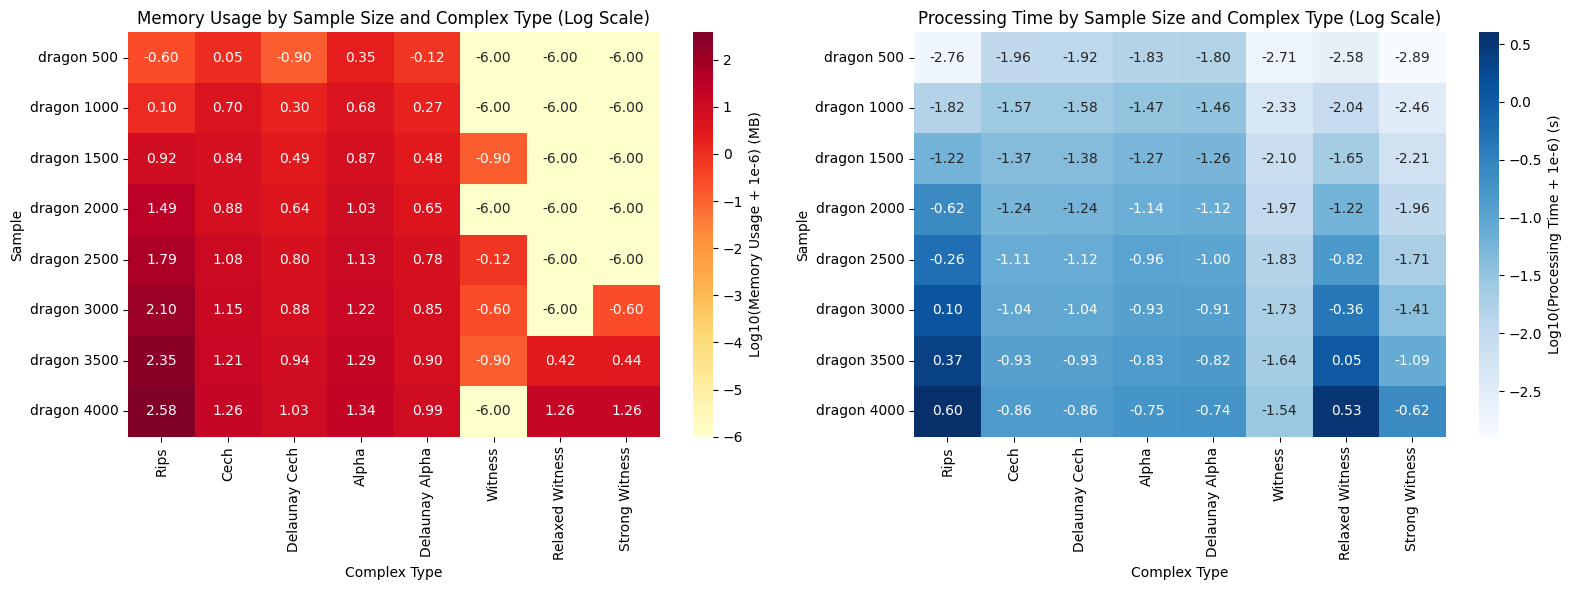


Original Memory Usage Statistics (MB):
             Rips       Cech  Delaunay Cech      Alpha  Delaunay Alpha  \
count    8.000000   8.000000       8.000000   8.000000        8.000000   
mean   104.468262  10.171875       5.375000  12.062500        5.109375   
std    136.291137   5.979480       3.586308   7.046719        3.124241   
min      0.250000   1.125000       0.125000   2.250000        0.750000   
25%      6.500000   6.406250       2.843750   6.718750        2.718750   
50%     46.115234   9.812500       5.375000  12.062500        5.250000   
75%    151.391602  14.656250       7.906250  17.406250        7.312500   
max    381.902344  18.375000      10.625000  21.875000        9.750000   

        Witness  Relaxed Witness  Strong Witness  
count  8.000000         8.000000        8.000000  
mean   0.156250         2.578125        2.656250  
std    0.256609         6.298716        6.372286  
min    0.000000         0.000000        0.000000  
25%    0.000000         0.000000      

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract data for heatmaps
sample_names = list(complex_res.keys())
complex_types = list(complex_res[sample_names[0]].keys())

# Create matrices for memory and time data
memory_data = []
time_data = []

for sample in sample_names:
    memory_row = []
    time_row = []
    for complex_type in complex_types:
        memory_row.append(complex_res[sample][complex_type].memory_usage_mb)
        time_row.append(complex_res[sample][complex_type].processing_time_s)
    memory_data.append(memory_row)
    time_data.append(time_row)

# Convert to DataFrames for easier plotting
memory_df = pd.DataFrame(memory_data, 
                        index=sample_names, 
                        columns=[ct.replace('_', ' ').title() for ct in complex_types])
time_df = pd.DataFrame(time_data, 
                      index=sample_names, 
                      columns=[ct.replace('_', ' ').title() for ct in complex_types])

# Apply logarithmic transformation (add small value to avoid log(0))
log_memory_df = np.log10(memory_df + 1e-6)
log_time_df = np.log10(time_df + 1e-6)

# Create heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Memory usage heatmap (logarithmic)
sns.heatmap(log_memory_df, annot=True, fmt='.2f', cmap='YlOrRd', 
            ax=ax1, cbar_kws={'label': 'Log10(Memory Usage + 1e-6) (MB)'})
ax1.set_title('Memory Usage by Sample Size and Complex Type (Log Scale)')
ax1.set_xlabel('Complex Type')
ax1.set_ylabel('Sample')

# Processing time heatmap (logarithmic)
sns.heatmap(log_time_df, annot=True, fmt='.2f', cmap='Blues', 
            ax=ax2, cbar_kws={'label': 'Log10(Processing Time + 1e-6) (s)'})
ax2.set_title('Processing Time by Sample Size and Complex Type (Log Scale)')
ax2.set_xlabel('Complex Type')
ax2.set_ylabel('Sample')

plt.tight_layout()
plt.show()

# Print summary statistics for original and log-transformed data
print("\nOriginal Memory Usage Statistics (MB):")
print(memory_df.describe())
print("\nLog10 Memory Usage Statistics:")
print(log_memory_df.describe())

print("\nOriginal Processing Time Statistics (s):")
print(time_df.describe())
print("\nLog10 Processing Time Statistics:")
print(log_time_df.describe())